In [1]:
%matplotlib notebook

import os
import random

from operator import itemgetter

import cv2
import numpy as np
import torch
import torch.optim as optim
import matplotlib.pyplot as plt

from albumentations import (
    CLAHE,
    Blur,
    OneOf,
    Compose,
    RGBShift,
    GaussNoise,
    RandomGamma,
    RandomContrast,
    RandomBrightness,
)

from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import MultiStepLR
from albumentations.pytorch.transforms import ToTensorV2
from albumentations.augmentations.transforms import HueSaturationValue
from albumentations.augmentations.transforms import Normalize

from trainer import Trainer, hooks, configuration
from detector import Detector
from trainer.utils import patch_configs
from trainer.utils import setup_system
from detection_loss import DetectionLoss
from trainer.encoder import (
    DataEncoder,
    decode_boxes,
    encode_boxes,
    generate_anchors,
    generate_anchor_grid,
)
from trainer.metrics import APEstimator
from trainer.datasets import ListDataset
from trainer.data_set_downloader import DataSetDownloader 
from trainer.matplotlib_visualizer import MatplotlibVisualizer

/home/rahul/.conda/envs/penv/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [2]:
class Experiment:
    def __init__(
        self,
        system_config: configuration.SystemConfig = configuration.SystemConfig(),
        dataset_config: configuration.DatasetConfig = configuration.DatasetConfig(),  # pylint: disable=redefined-outer-name
        dataloader_config: configuration.DataloaderConfig = configuration.DataloaderConfig(),  # pylint: disable=redefined-outer-name
        optimizer_config: configuration.OptimizerConfig = configuration.OptimizerConfig(),  # pylint: disable=redefined-outer-name
    ):
        self.system_config = system_config
        setup_system(system_config)
        self.dataset_train = ListDataset(
            root_dir=dataset_config.root_dir,
            list_file='../train_anno.txt',
            classes=["__background__", "person"],
            mode='train',
            transform=Compose(dataset_config.train_transforms),
            input_size=300
        )

        self.loader_train = DataLoader(
            dataset=self.dataset_train,
            batch_size=dataloader_config.batch_size,
            shuffle=True,
            collate_fn=self.dataset_train.collate_fn,
            num_workers=dataloader_config.num_workers,
            pin_memory=True
        )

        self.dataset_test = ListDataset(
            root_dir=dataset_config.root_dir,
            list_file='../test_anno.txt',
            classes=["__background__", "person"],
            mode='val',
            transform=Compose([Normalize(), ToTensorV2()]),
            input_size=300
        )
        self.loader_test = DataLoader(
            dataset=self.dataset_test,
            batch_size=dataloader_config.batch_size,
            shuffle=False,
            collate_fn=self.dataset_test.collate_fn,
            num_workers=dataloader_config.num_workers,
            pin_memory=True
        )
        self.model = Detector(len(self.dataset_train.classes))
        self.loss_fn = DetectionLoss(len(self.dataset_train.classes))
        self.metric_fn = APEstimator(classes=self.dataset_test.classes)
        self.optimizer = optim.SGD(
            self.model.parameters(),
            lr=optimizer_config.learning_rate,
            weight_decay=optimizer_config.weight_decay,
            momentum=optimizer_config.momentum
        )
        self.lr_scheduler = MultiStepLR(
            self.optimizer, milestones=optimizer_config.lr_step_milestones, gamma=optimizer_config.lr_gamma
        )
        self.visualizer = MatplotlibVisualizer()

    def run(self, trainer_config: configuration.TrainerConfig):
        setup_system(self.system_config)
        device = torch.device(trainer_config.device)
        self.model = self.model.to(device)
        self.loss_fn = self.loss_fn.to(device)

        model_trainer = Trainer(
            model=self.model,
            loader_train=self.loader_train,
            loader_test=self.loader_test,
            loss_fn=self.loss_fn,
            metric_fn=self.metric_fn,
            optimizer=self.optimizer,
            lr_scheduler=self.lr_scheduler,
            device=device,
            data_getter=itemgetter("image"),
            target_getter=itemgetter("target"),
            stage_progress=trainer_config.progress_bar,
            get_key_metric=itemgetter("mAP"),
            visualizer=self.visualizer,
            model_save_best=trainer_config.model_save_best,
            model_saving_frequency=trainer_config.model_saving_frequency,
            save_dir=trainer_config.model_dir
        )

        model_trainer.register_hook("train", hooks.train_hook_detection)
        model_trainer.register_hook("test", hooks.test_hook_detection)
        model_trainer.register_hook("end_epoch", hooks.end_epoch_hook_detection)
        self.metrics = model_trainer.fit(trainer_config.epoch_num)
        return self.metrics

    def draw_bboxes(self, rows, columns, trainer_config: configuration.TrainerConfig):
        # load the best model
        if trainer_config.model_save_best:
            self.model.load_state_dict(
                torch.
                load(os.path.join(trainer_config.model_dir, self.model.__class__.__name__) + '_best.pth')
            )
        # or use the last saved
        self.model = self.model.eval()

        std = (0.229, 0.224, 0.225)
        mean = (0.485, 0.456, 0.406)

        std = torch.Tensor(std)
        mean = torch.Tensor(mean)

        fig, ax = plt.subplots(
            nrows=rows, ncols=columns, figsize=(10, 10), gridspec_kw={
                'wspace': 0,
                'hspace': 0.05
            }
        )

        for axi in ax.flat:
            index = random.randrange(len(self.loader_test.dataset))

            image, gt_boxes, _ = self.loader_test.dataset[index]

            device = torch.device(trainer_config.device)
            image = image.to(device).clone()

            loc_preds, cls_preds = self.model(image.unsqueeze(0))

            with torch.no_grad():
                img = image.cpu()
                img.mul_(std[:, None, None]).add_(mean[:, None, None])
                img = torch.clamp(img, min=0.0, max=1.0)
                img = img.numpy().transpose(1, 2, 0)

                img = (img * 255.).astype(np.uint8)
                gt_img = img.copy()
                pred_img = img.copy()

                for box in gt_boxes:
                    gt_img = cv2.rectangle(
                        gt_img, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), (255, 0, 0),
                        thickness=2
                    )

                encoder = DataEncoder((img.shape[1], img.shape[0]))
                samples = encoder.decode(loc_preds, cls_preds)
                c_dets = samples[0][1]  # detections for class == 1

                if c_dets.size > 0:
                    boxes = c_dets[:, :4]
                    for box in boxes:
                        pred_img = cv2.rectangle(
                            pred_img, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), (0, 0, 255),
                            thickness=2
                        )

                merged_img = np.concatenate((gt_img, pred_img), axis=1)
                axi.imshow(merged_img)
                axi.axis('off')
        fig.show()

## Run Experiment

<IPython.core.display.Javascript object>


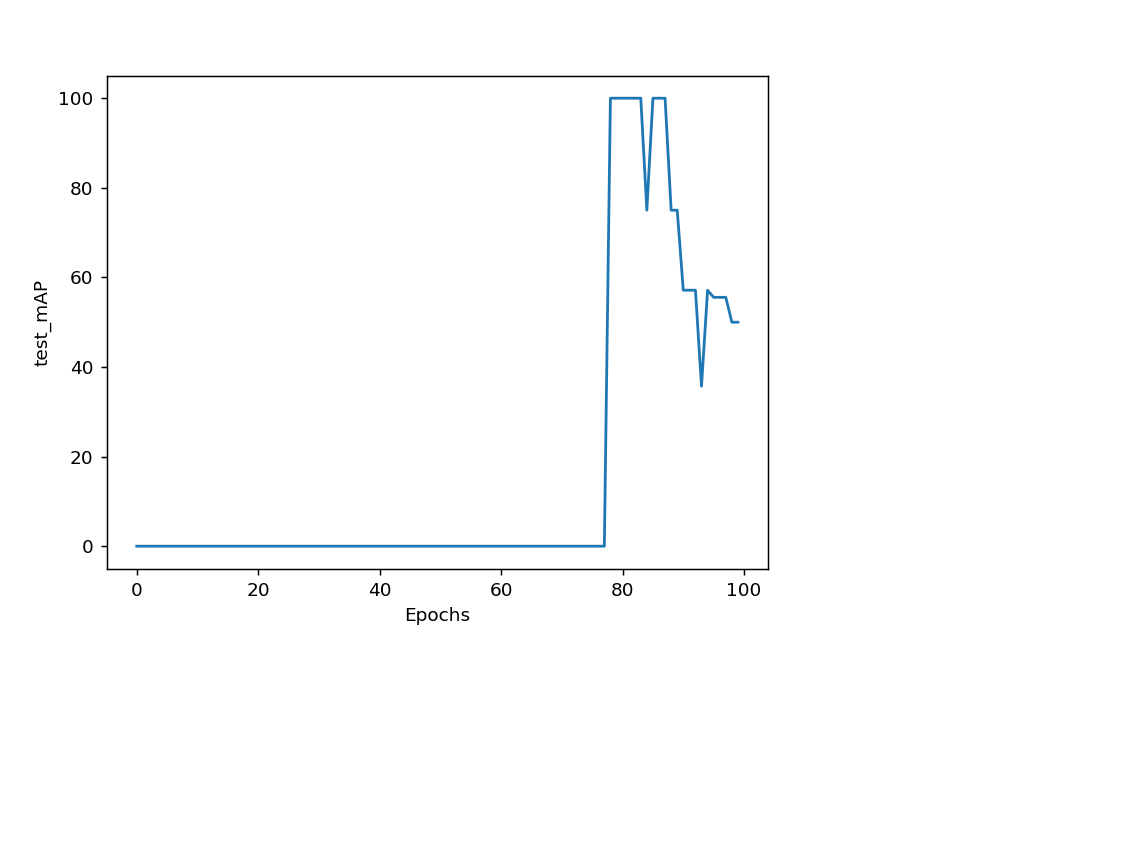

<IPython.core.display.Javascript object>


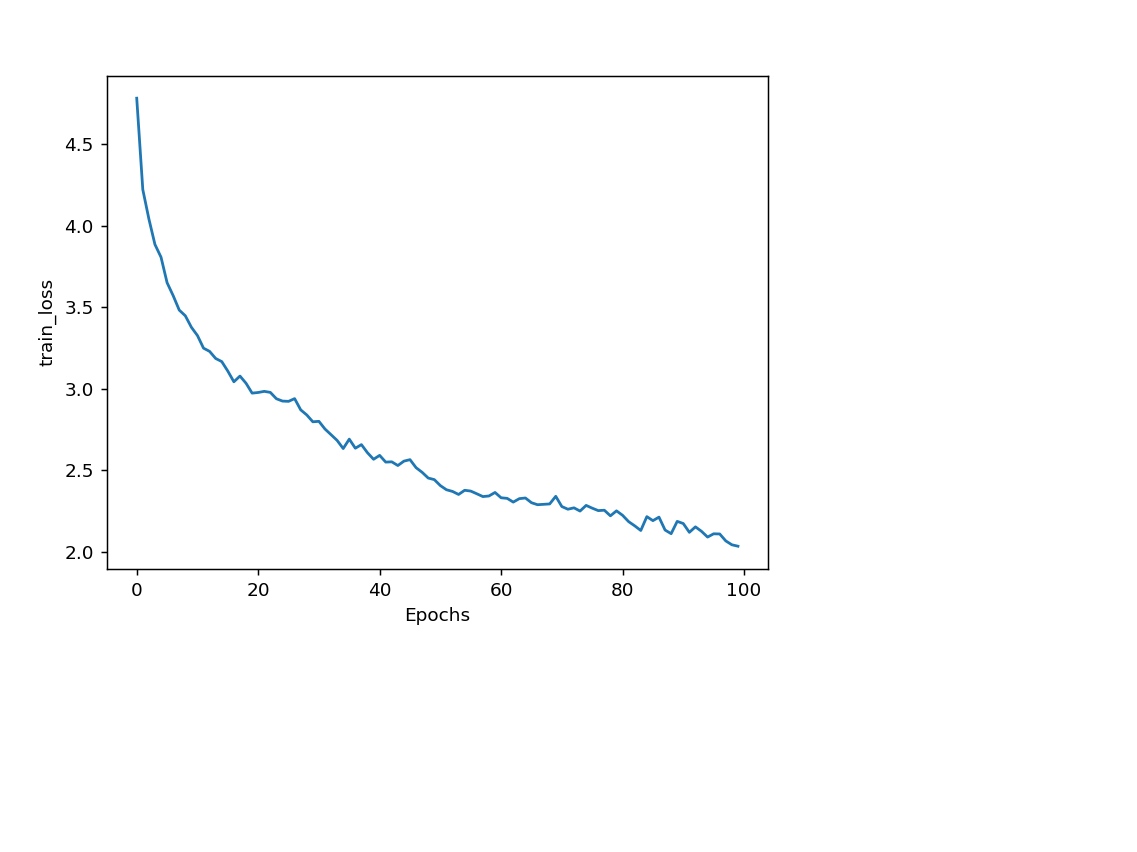

<IPython.core.display.Javascript object>


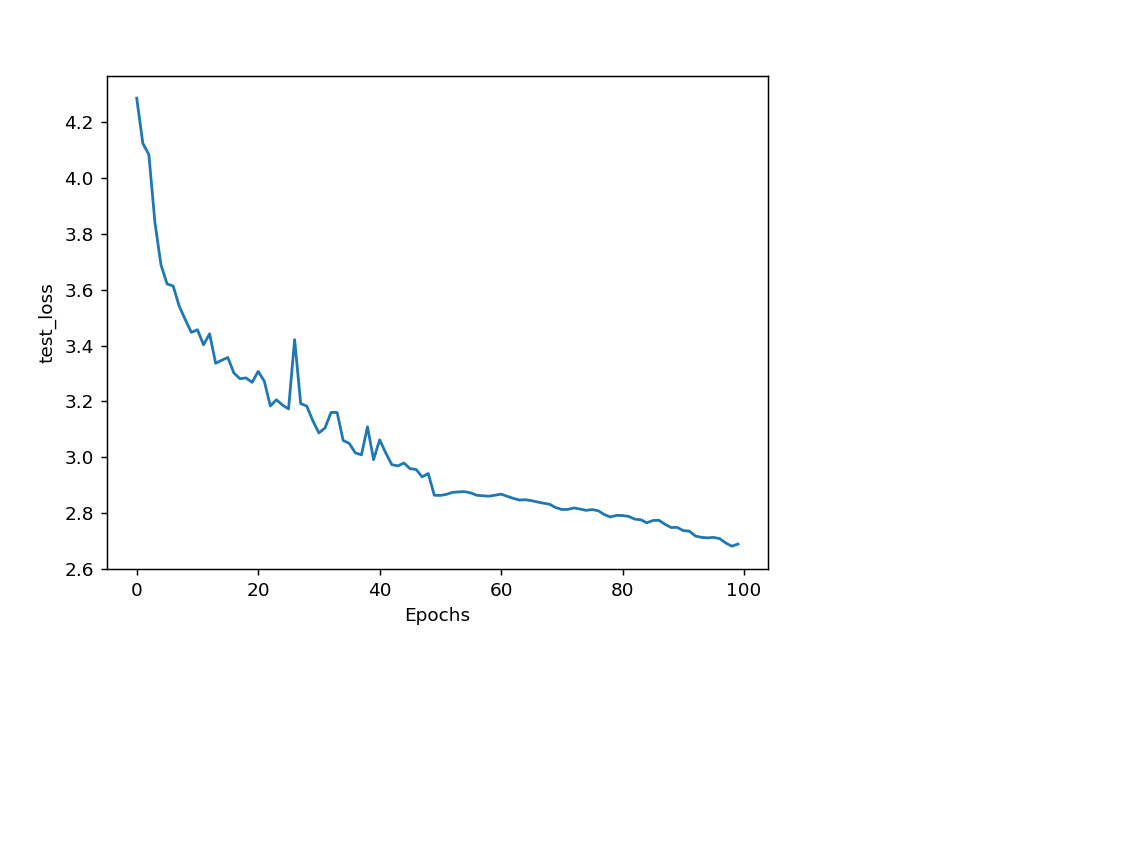

<IPython.core.display.Javascript object>


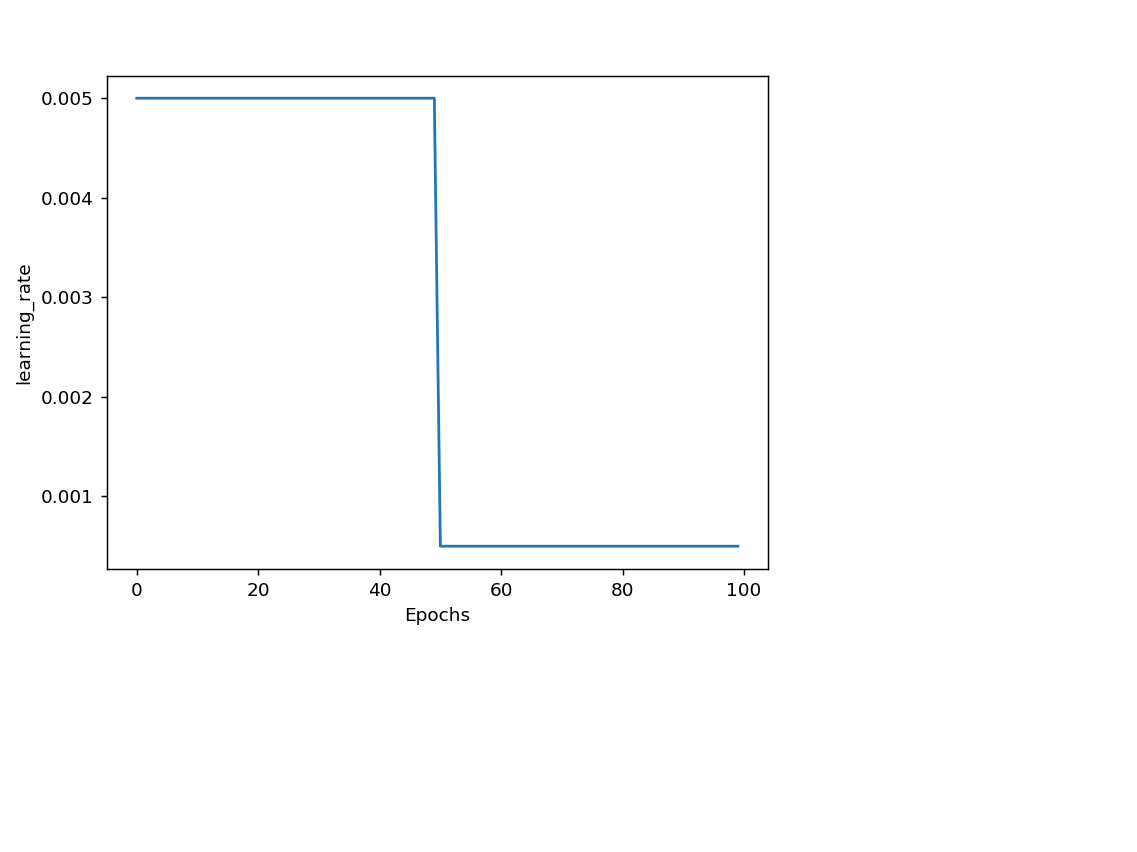

<IPython.core.display.Javascript object>


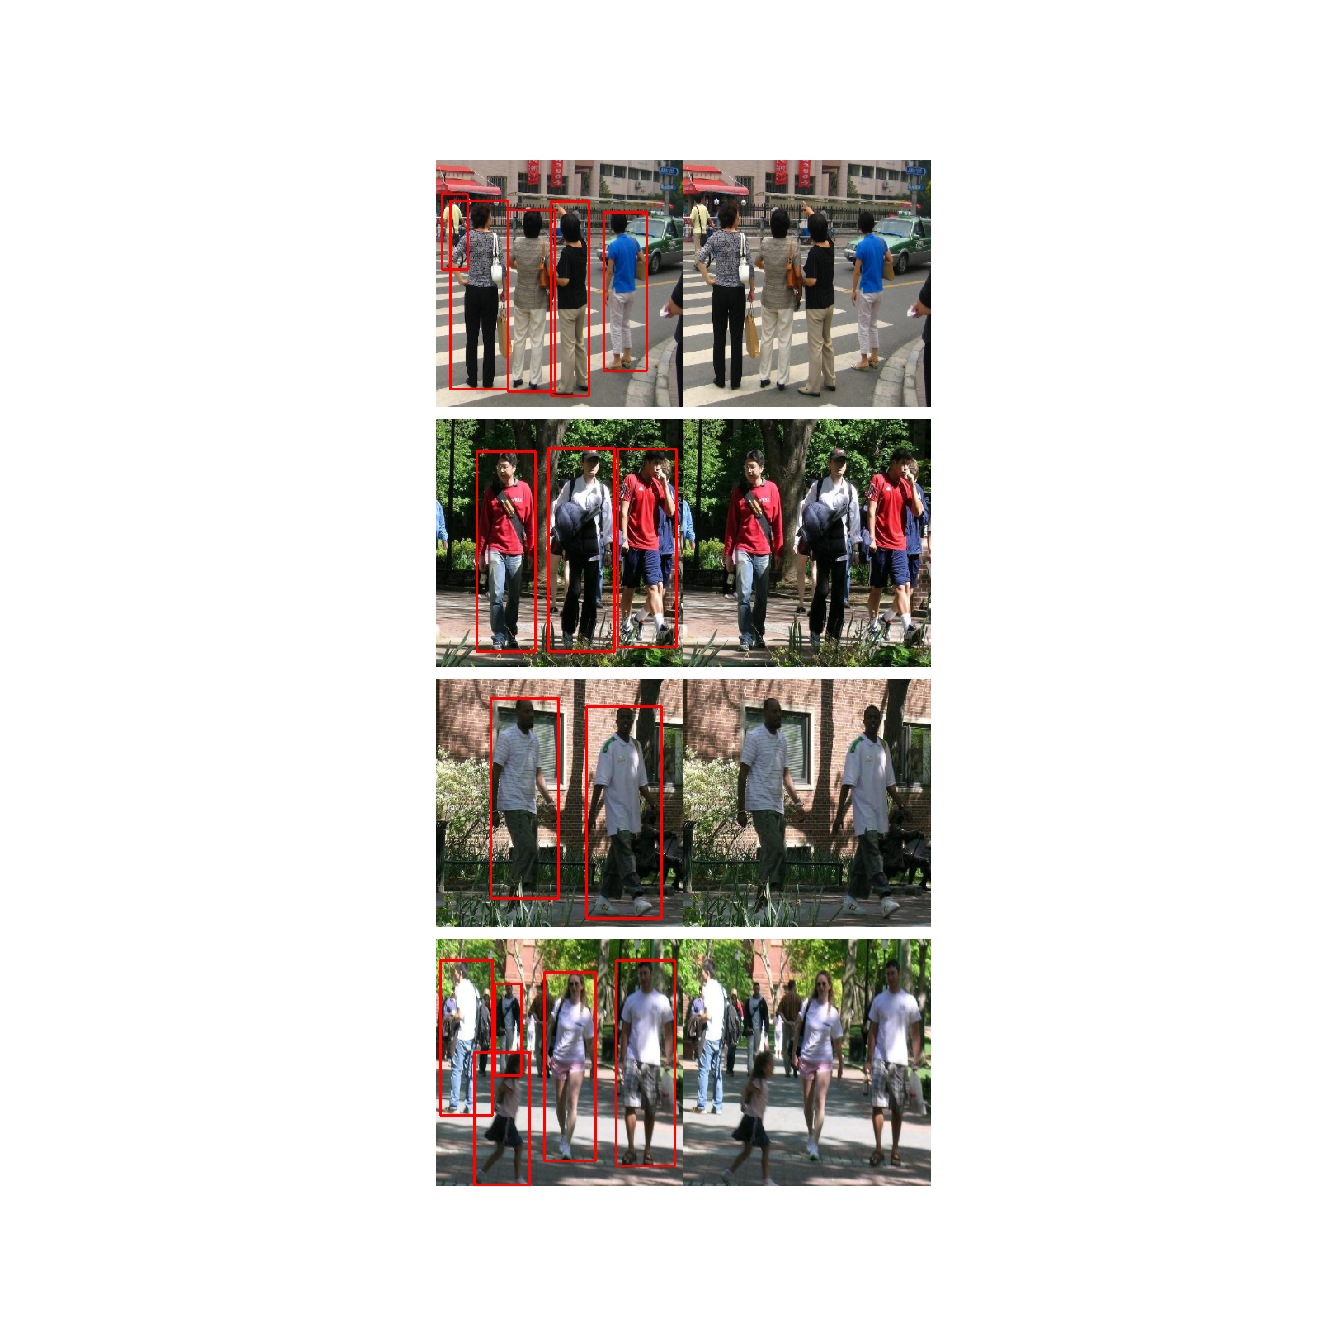

In [5]:
if __name__ == '__main__':
    dataloader_config, trainer_config = patch_configs(epoch_num_to_set=100, batch_size_to_set=30)
    dataset_config = configuration.DatasetConfig(
        root_dir="data/PennFudanPed/",
        train_transforms=[
            RandomBrightness(p=0.5),
            RandomContrast(p=0.5),
            OneOf([
                RandomGamma(),
                HueSaturationValue(hue_shift_limit=20, sat_shift_limit=50, val_shift_limit=50),
                RGBShift()
            ],
                p=1),
            OneOf([Blur(always_apply=True), GaussNoise(always_apply=True)], p=1),
            CLAHE(),
            Normalize(),
            ToTensorV2()
        ]
    )
    
    optimizer_config = configuration.OptimizerConfig(
        learning_rate=5e-3, 
        lr_step_milestones=[50], 
        lr_gamma=0.1, 
        momentum=0.9, 
        weight_decay=1e-5
    )
    
    experiment = Experiment(
        dataset_config=dataset_config, 
        dataloader_config=dataloader_config, 
        optimizer_config=optimizer_config
    )
    
    # Run the experiment / start training
    experiment.run(trainer_config)
    
    # how good our detector works by visualizing the results on the randomly chosen test images:
    experiment.draw_bboxes(4, 1, trainer_config)